# Relatório Calculo Numérico




### Alunos: 
Matheus Steigenberg Populim 10737410<br>
Bruno Gazoni 7585037<br>
Bruno Carlotto Baldissera 10724351<br>

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# 1 - Solução de Sistemas Lineares: métodos diretos e métodos iterativos (Comparação do desempenho dos métodos para matrizes de dimensão arbitrariamente grandes)


Dado um sistema linear da forma:

$$
\begin{align}
&a_{11}x_1& &+& &a_{12}x_2& &+& &\dots& &+& &a_{1n}x_n& &= b_1&\\
&a_{21}x_1& &+& &a_{22}x_2& &+& &\dots& &+& &a_{2n}x_n& &= b_2&\\
&\hspace{5mm}\vdots& &+& &\hspace{5mm}\vdots& &+& &\ddots& &+& &\hspace{5mm}\vdots& &= \vdots&\\
&a_{n1}x_1& &+& &a_{n2}x_2& &+& &\dots& &+& &a_{nn}x_n& &= b_n&\\
\end{align}
$$



Podemos representá-lo na forma matricial como:

$$
\left[ \begin{matrix}
a_{11}& a_{12}& \dots & a_{1n}\\
a_{21}& a_{22}& \vdots& a_{2n}\\
\vdots& \vdots& \ddots& \vdots\\
a_{n1}& a_{n2}& \dots& a_{nn}\\
\end{matrix} \right]
\left[ \begin{matrix}
x_0\\ x_1\\ \vdots \\ x_n\\ 
\end{matrix} \right] = 
\left[ \begin{matrix}
b_0\\ b_1\\ \vdots \\ b_n\\ 
\end{matrix} \right]
$$

$$Ax=b$$

Para calcular o valor do vetor $x$ e resolver esses sistemas, podemos utilizar métodos diretos e iterativos.

## Métodos diretos

Métodos diretos nos fornecem soluções exatas para um sistema de equações em um número finito de passos, dadas as limitações do sistema.

### Regra de Cramer



O método de Cramer é um dos mais antigos para a resolução de sistemas lineares. e pode ser calculado da seguinte forma:

$$x_{i}={\frac {\det(A_{i})}{\det(A)}}\qquad i=1,\ldots ,n$$

No qual $det(A_i)$ é o determinante da matrix A ao substituir a coluna $i$ pelo vetor $b$.

Vamos criar um sistema para testar esse método:

In [ ]:
A = np.array(([1,2,3],[4,2,1,],[2,2.5,1.6]))
x = np.array([4.2,7.5,2])
b = A.dot(x)
print(b)

[25.2  33.8  30.35]


Agora temos a matriz $A$, o vetor $b$, e o vetor $x$ original para verificarmos nosso resultado.

Como dito, para descobrirmos cada valor de $x_i$, temos que substituir a coluna $i$ da matriz $A$ pelo vetor $b$:

In [ ]:

def cramer(A,b):
    x = np.zeros((len(b)))
    determinante = np.linalg.det(A)
    for i in range(len(A)):
        Aux = np.copy(A)
        Aux[:,i] = b
        x[i] = np.linalg.det(Aux)/determinante
    return x

print(cramer(A,b))
print(x)

[4.2 7.5 2. ]
[4.2 7.5 2. ]


Podemos ver que o método funciona muito bem para esse caso. No entanto, há um motivo pelo qual a regra de Cramer é mais lembrada por seu valor histórico do que pela sua funcionalidade: calcular determinantes de matrizes grandes é uma operação extremamente demorada e sujeita a grandes erros de precisão numérica.

tempo passado: 5.30243182182312


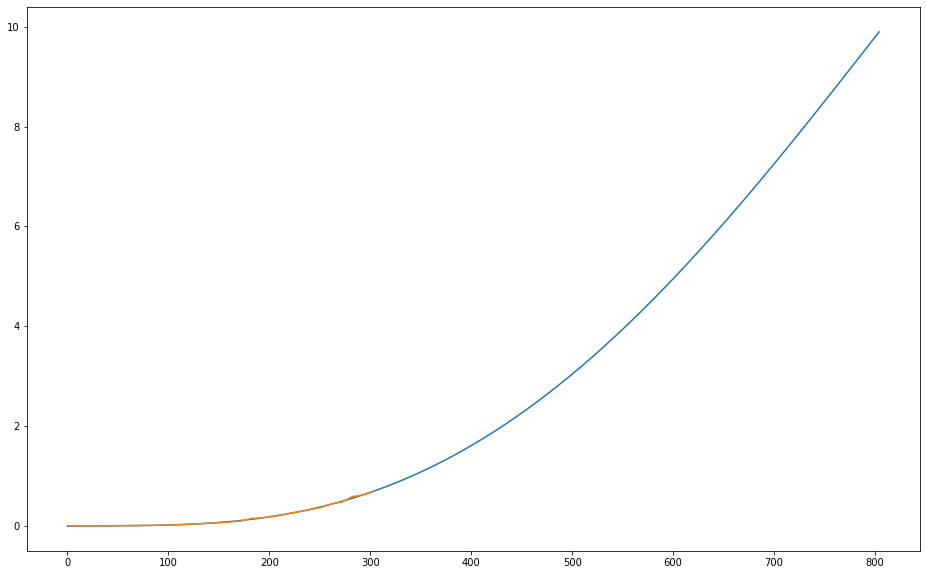

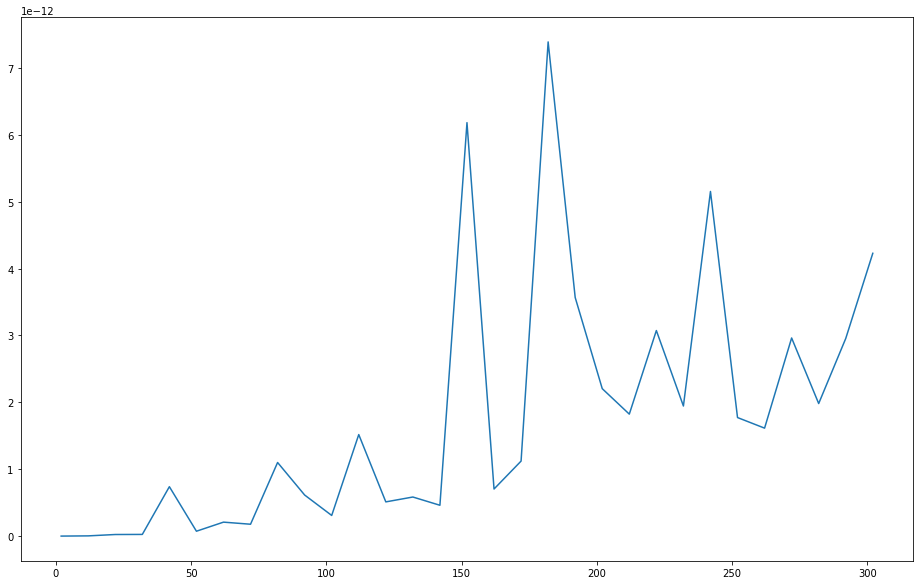

In [ ]:
def create_random_system(n):
    A = np.random.rand(n,n)
    x = np.random.rand(n)
    b = A.dot(x)
    return A,x,b

size = list()
tempo = list()
erro = list()
comeco = time.time()
for i in range(2,303,10):
    A,x,b = create_random_system(i)
    #print(len(A))
    inicio = time.time()
    resultado = cramer(A,b)
    tempo.append(time.time()-inicio)
    size.append(i)
    erro.append(np.linalg.norm(resultado-x))
print("tempo passado:", time.time()-comeco)


polinomio = np.polyfit(size,tempo,4)
x = range(805)
y = np.polyval(polinomio,x)

plt.rcParams['figure.figsize'] = (16,10)
plt.plot(x,y)
plt.plot(size,tempo)
plt.show()

A complexidade desse método é de O(n^4) ao calcular o determinante através da decomposição LU, que é a utilizada pela função np.linalg.det.<br>
Além disso, ao utilizar o método para matrizes com $N>500$, ocorreu overflow dos valores calculados, impossibilitando seu uso para quaisquer valores que não sejam muito pequenos.

Por isso, vamos seguir para outros métodos de resolução de sistemas lineares.

### Eliminação Gaussiana

Com esse método fazemos uso da composição de três operações matriciais elementares para simplificarmos o sistema linear e então resolvê-lo. São elas: 

  $L_1$: Trocar duas linhas de lugar, uma pela outra.
  
  $L_2$: Multiplicar por um escalar $\neq 0$ todos os componentes em uma linha.

  $L_3$: Substituir uma linha pela soma dela mesma com um múltiplo escolhido de outra.

  Fazendo uso dessas operações de uma forma algorítmica, durante a etapa de eliminação do método, transformamos a matriz de um sistema linear por uma equivalente na forma escalonada (matriz triangular superior), em que as operações para resolução do sistema se tornam triviais.

  Então substituem-se os valores e resolvem-se as equações em cascata, já que uma equação se tornou trivial, então substituimos o valor dessa incógnita nas equações superiores, e assim por diante. Essa etapa é chamada de substituição regressiva.

In [ ]:
def gauss(A):
    m = len(A)
    assert all([len(row) == m + 1 for row in A[1:]]), "Linhas da matriz tem comprimento não uniforme"
    n = m + 1
    
    for k in range(m):
        pivots = [abs(A[i][k]) for i in range(k, m)]
        i_max = pivots.index(max(pivots)) + k
        
        # checa se ela é singular
        assert A[i_max][k] != 0, "Matriz é singular!"
        
        # troca linhas
        A[k], A[i_max] = A[i_max], A[k]

        
        for i in range(k + 1, m):
            f = A[i][k] / A[k][k]
            for j in range(k + 1, n):
                A[i][j] -= A[k][j] * f

            # preenche a parte debaixo com 0
            A[i][k] = 0
    
    # resolve o sistema        
    x = []
    for i in range(m - 1, -1, -1):
        x.insert(0, A[i][m] / A[i][i])
        for k in range(i - 1, -1, -1):
            A[k][m] -= A[k][i] * x[0]
    return x

### Método de Cholesky

O método de Cholesky é utilizado para sistemas lineares cuja matriz $A$ é simétrica e positiva definida. Uma matriz é simétrica quando $a_{ij} = a_{ji}, \forall i,j$. E uma matriz é dita positiva definida se todos seus autovalores são maiores que 0.<br>
Esse método é muito útil para resolver sistemas no contexto de problemas que envolvam simetria. Por exemplo, um problema que possa ser representado por um grafo não-direcionado apresenta sempre uma matriz de adjacência simétrica.

A decomposição de Cholesky permite escrever uma matriz $A$ como o produto de uma matriz triangular por sua conjugada transposta.
$${\displaystyle \mathbf {A} =\mathbf {LL} ^{*}}$$
Como trataremos apenas de números reais, podemos desconsiderar a conjugação:
$${\displaystyle \mathbf {A} =\mathbf {LL} ^{T}}$$

In [ ]:
def cholesky(A):
    n = A.shape[0]
    # Cria uma matriz de zeros
    L = np.zeros((n,n))

    for i in range(n):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            if (i == k):
                L[i][k] = np.sqrt(A[i][i] - tmp_sum)
            else:
                L[i][k] = (1.0 / L[k][k] * (A[i][k] - tmp_sum))
    return L

Por fim, podemos resolver a matriz triangular simplesmente a partir do método já implementado.

Como exemplo, utilizaremos o sistema de equações do Trabalho 1.

In [ ]:
def create_simmetric_system(n):
    A = np.zeros((n,n))
    b = np.zeros(n)
    for i in range(n):
        b[i] = 1/n**4
    for i in range(0,n):
        A[i,i] = 6 #diagonal principal
    for i in range(0,n-1):
        A[i,i+1] = -4 #diagonal acima da principal
        A[i+1,i] = -4 #diagonal abaixo da principal
    for i in range(0,n-2):
        A[i,i+2] = 1
        A[i+2,i] = 1 #diagonais mais distantes  
    return A,b

In [ ]:
n = 100
A,b = create_simmetric_system(n)

Agora é só inserir os números que não se repetem ao longo das diagonais:

In [ ]:
A[0,0] = 9
A[-1,-1] = 1
A[-2,-2] = 5
A[-1,-2] = -2
A[-2,-1] = -2

In [ ]:
A

array([[ 9., -4.,  1., ...,  0.,  0.,  0.],
       [-4.,  6., -4., ...,  0.,  0.,  0.],
       [ 1., -4.,  6., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  6., -4.,  1.],
       [ 0.,  0.,  0., ..., -4.,  5., -2.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

O método de Cholesky retorna uma matriz triangular. Para resolvê-la, devemos implementar o método:

In [ ]:
def solve_triangular_system(L,b):
    n = L.shape[0]
    x = np.zeros((n))
    for i in range(n):
        soma = 0
        for j in range(0,i):
            soma += L[i,j]*x[j]
        x[i] = (b[i] - soma)/L[i,i]
    return x

In [ ]:
def solve_triangular_system_backwards(L,b):
    n = L.shape[0]
    x = np.zeros((n))
    for i in range(n-1,0-1,-1):
        soma = 0
        for j in range(n-1,i,-1):
            soma += L[i,j]*x[j]
        x[i] = (b[i] - soma)/L[i,i]
    return x

In [ ]:
def solve_cholesky_system(A,b):
    L = cholesky(A)
    y = solve_triangular_system(L,b)
    x = solve_triangular_system_backwards(np.transpose(L),y)
    return x    

In [ ]:
A,b = create_simmetric_system(10)
x = solve_cholesky_system(A,b)
print(x)

[0.00091667 0.00225    0.0036     0.00466667 0.00525    0.00525
 0.00466667 0.0036     0.00225    0.00091667]


Comparando com a função np.linalg.solve do Numpy, vemos que a solução correta foi obtida:

In [ ]:
x_test = np.linalg.solve(A,b)
print(x_test)

[0.00091667 0.00225    0.0036     0.00466667 0.00525    0.00525
 0.00466667 0.0036     0.00225    0.00091667]


### -------------------------------------------------------------------------------------------------------------------------------------

## Métodos Iterativos


Para o métodos de Gauss Jacobi, a ideia é gerar uma sequência de vetores ${x_0, x_1, ... , x_n}$ que convirja para a solução da equação Ax = b. Para isso, transformamos $Ax = b$ em um sistema equivalente da forma $x = Cx + g$, sendo C uma matriz quadrada de n linhas e colunas e g uma constante pertencente ao $\mathcal R^n$. Escolhemos C e g, e assim conhecemos o resultado dessa equação. Recursivamente, assim, transformamos equações matriciais em equações conhecidas diversas vezes até que a solução convirja suficientemente para nossos propósitos.

O método de Gauss Seidel reutiliza os valores das equações recursivas nas próximas rodadas. Isso acelera a convergência do método, porém significa que as recursões necessitam do resultado da recursão anterior, impossibilitando sua paralelização.

In [ ]:
def seidel(a,b,t=5000,x=None): 
    if x is None:
        x = np.zeros(len(A[0]))      
    n = len(a)                   
    # calcula os valores para cada iteração
    for iterations in range(t):
        for j in range(0, n):         
            d = b[j]                   
            for i in range(0, n):      
                if(j != i): 
                    d-=a[j][i] * x[i]        
            x[j] = d / a[j][j]            
    return x

In [ ]:
solution_seidel = seidel(A,b)
solution = np.linalg.solve(A,b)
print(np.round(solution-solution_seidel,decimals=4))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create an initial guess if needed                                                                                                                                                            
    if x is None:
        x = np.zeros(len(A[0]))
    # Create a vector of the diagonal elements of A                                                                                                                                                
    # and subtract them from A                                                                                                                                                                     
    D = np.diag(A)
    R = A - np.diagflat(D)
                                                                                                                                             
    for i in range(N):
        x = (b - np.dot(R,x)) / D
    return x

In [ ]:
initial2 = np.zeros(10)
solution_jacobi = jacobi(A,b,N=25,x=initial2)

(10,)
(10, 10)
(10,)


In [ ]:
print(solution_jacobi)

[2.91918160e-04 5.42036510e-05 6.31854927e-04 2.52471439e-04
 5.24337659e-04 5.24337659e-04 2.52471439e-04 6.31854927e-04
 5.42036510e-05 2.91918160e-04]


In [ ]:
print(np.round(solution-solution_jacobi,decimals=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Podemos ver também a evolução dos métodos e o tempo gasto por cada um.

10
20
30
40
50
60
70
80
90


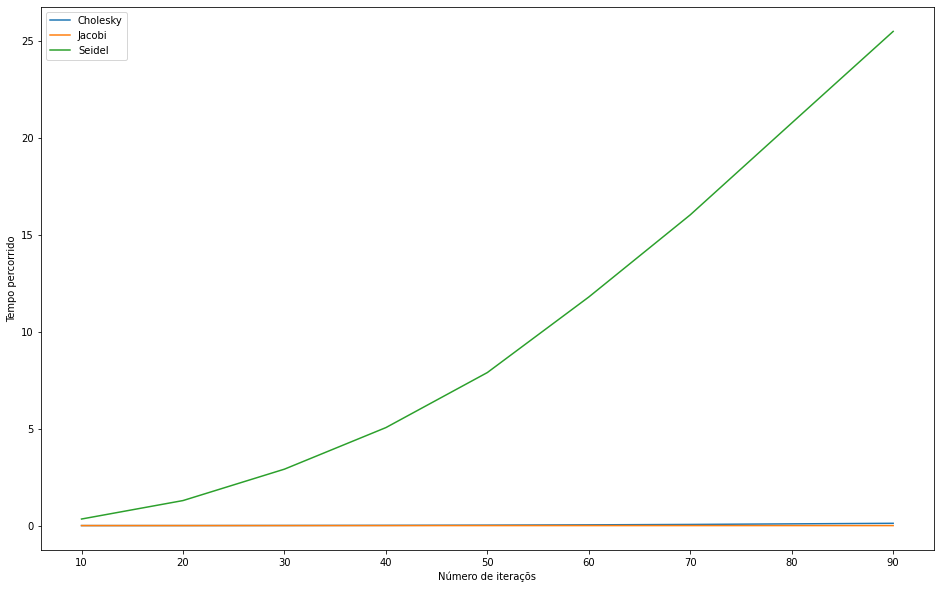

In [ ]:
n_iterations = list()
time_elapsed = list()
tempo_jacobi = list()
tempo_seidel = list()
for n in range(10,100,10):
    print(n)
    n_iterations.append(n)

    A,b = create_simmetric_system(n)

    start = time.time()
    solution = solve_cholesky_system(A,b)
    time_elapsed.append(time.time()-start)

    start = time.time()
    solution = jacobi(A,b,N=25)
    tempo_jacobi.append(time.time()-start)

    start = time.time()
    solution = seidel(A,b)
    tempo_seidel.append(time.time()-start)


plt.plot(n_iterations,time_elapsed,label='Cholesky')
plt.plot(n_iterations,tempo_jacobi,label='Jacobi')
plt.plot(n_iterations,tempo_seidel,label='Seidel')

plt.ylabel('Tempo percorrido')
plt.xlabel('Número de iteraçõs')
plt.legend()
plt.show()

# ------------------------------------------------------------------------------------------------------

# 2 - Métodos de Autovalores e Autovetores (Decomposição SVD e compressão de imagem, Google pagerank)


## Método de Francis

No método de Francis, utilizaremos decomposição QR para determinar todos os autovalores e autovetores de uma matriz quadrada simétrica A. Partiremos da decomposição de $A_1$ em $Q_1R_1$, invertemos sua multiplicação para gerar $A_2$ (isto é, $A_2 = R_1Q_1$), que por sua vez também será decomposta em $Q$ e $R$, sucessivamente:

$A_{k-1} = R_{k-1}Q{k-1}$

Sabemos que, por este processo, todas as matrizes $A_k$ possuíram os mesmos autovalores. O algoritmo converge a uma matriz diagonal, cujos elementos na diagonal aproximam os autovalores de $A$, enquanto que suas colunas aproximam seus autovetores.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def francis(A,tol):
    n = A.shape[0]
    V = np.identity(n)
    error = np.inf
    
    while(error>tol):
        Q,R = np.linalg.qr(A)
        A = np.dot(R,Q)
        V = np.dot(V,Q)
        error = np.linalg.norm(A-np.diag(np.diag(A)))
        
    D = np.diag(A)
    
    return V,D

In [ ]:
def SVD(A):
    tol = 0.00001
    m,n = A.shape
    k = min(m,n)
    S = np.zeros((m,n))
    
    U, y = francis(np.dot(A,np.transpose(A)),tol)
    V,D = francis(np.dot(np.transpose(A),A),tol)
    S[0:k,0:k] = np.diag(np.sqrt(D))
    
    return U,S,V

In [ ]:
A,b = create_simmetric_system(100)

In [ ]:
U,S,V = SVD(A)
#U = np.round(U,decimals=3) 
#S = np.round(S,decimals=3)
#V = np.round(V,decimals=3)

# --------------------------------------------------------------------------------------------------

Podemos usar também a decomposição QR para comprimir imagens:

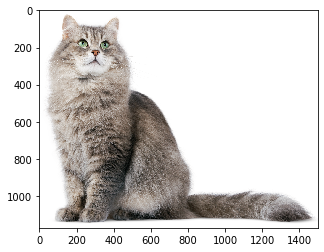

In [ ]:
imagem = plt.imread('gato.png')
plt.imshow(imagem)

In [ ]:
print(imagem.shape)

(1172, 1500, 4)


In [ ]:
for i in range(imagem.shape[0]):
    for j in range(imagem.shape[1]):
        pixel = imagem[i,j]
        r = pixel[0]
        g = pixel[1]
        b = pixel[2]
        alpha = pixel[3] #transparencia
        
        r = (r *.299)
        g = (g *.587)
        b = (b *.114)
        
        v = (r+g+b)
        if(alpha==0):
            v = 1
        
        pixel = [v,v,v,1]
        
        imagem[i,j] = pixel
        

In [ ]:
plt.rcParams['figure.figsize'] = (16,10)

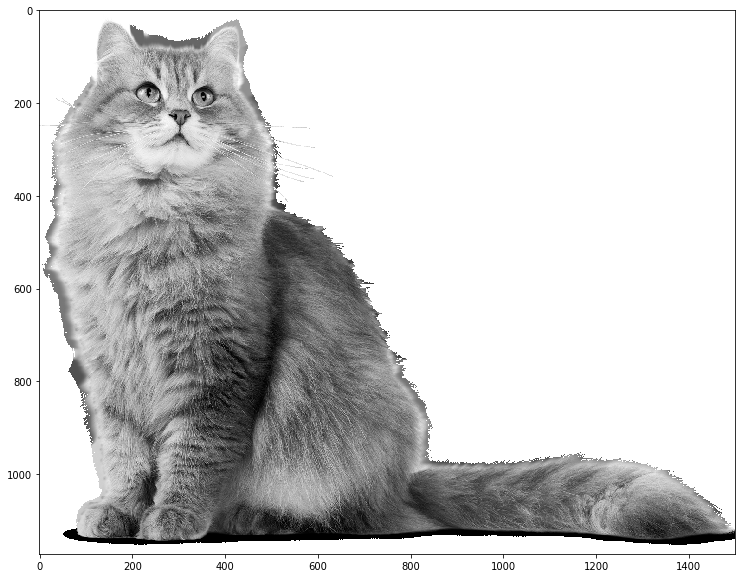

In [ ]:
plt.imshow(imagem)

Ao tornar a imagem preto e branco, facilitamos o processo.

In [ ]:
print(imagem[1130,800])

[0. 0. 0. 1.]


In [ ]:
A = np.zeros((imagem.shape[0],imagem.shape[1]))
A[:,:] = imagem[:,:,0]

k = min(A.shape[0],A.shape[1])

In [ ]:
U, S, V = np.linalg.svd(A)
k = 15

Em seguida, criamos uma nova matriz que será formada por apenas um pedaço da matriz original:

In [ ]:
A_k = np.dot(U[:,:k],np.dot(np.diag(S)[:k,:k],V[:k,:]))

In [ ]:
A_k.shape

(1172, 1500)

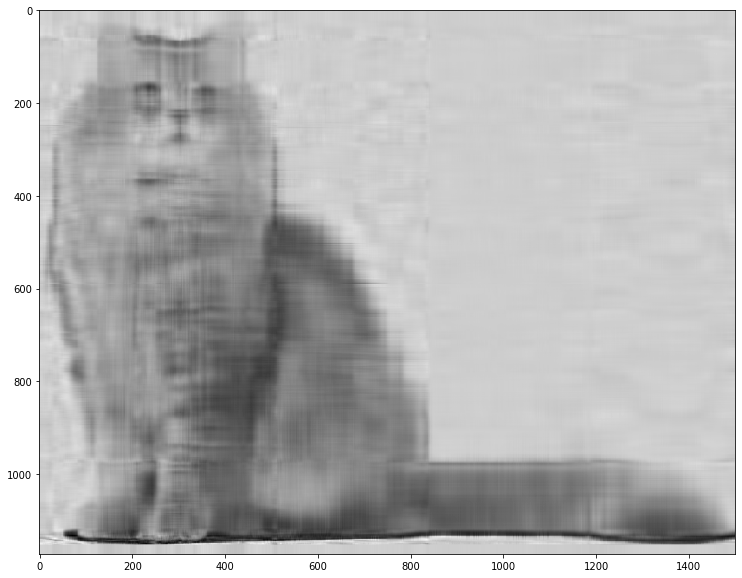

In [ ]:
plt.imshow(A_k,cmap='gray')

### Exercício 3

Primeiramente, decompondo a matriz em LU

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
A = np.array([[1,4,3],[9,8,7],[2,5,2]])

In [ ]:
def fatoraLU(A):
    n = np.shape(A)[0]
    L = np.eye(n) 
    U = np.zeros((n,n))
    for k in range(n):
        for j in range(k,n):
            soma = 0
            for s in range(k):
                soma += L[k,s]*U[s,j]
            U[k,j] = A[k,j] - soma
        for i in range(k+1,n):
            L[i,k]=A[i,k]
            for s in range(k):
                L[i,k]=L[i,k]-L[i,s]*U[s,k]
            L[i,k]=L[i,k]/U[k,k]
    return L, U   

In [ ]:
L,U = fatoraLU(A)

In [ ]:
print(L)
print(U)
print(L.dot(U))

[[1.         0.         0.        ]
 [9.         1.         0.        ]
 [2.         0.10714286 1.        ]] 
 [[  1.           4.           3.        ]
 [  0.         -28.         -20.        ]
 [  0.           0.          -1.85714286]] 
 [[1. 4. 3.]
 [9. 8. 7.]
 [2. 5. 2.]]


# 3 - Solução de Equações e Sistemas Não-Lineares (Aplicações do método de Newton para sistemas)

O método de Newton é utilizado para resolver um sistema de equações não lineares.<br>

Inicialmente, veremos o que é o método de Newton.

Suponha que queremos encontrar o zero de uma função $f(x)$. Para isso, o método de Newton se baseia em chutar um ponto $x_0$ qualquer da curva, calcular a reta tangente daquele ponto, verificar onde a reta tangente intercepta o eixo x, se mover para este próximo $x_{1}$, e assim por diante, até um número definido de iterações, até que $f(x_{n})$ esteja suficientemente próxima de 0, ou até que $|f(x_{n+1}) - f(x_{n})|< \epsilon$, para um $\epsilon$  definido.

Calculando a reta tangente a um ponto $x_n$:
$$y=f'(x_{n})\,(x-x_{n})+f(x_{n})$$


Verificando onde a reta intercepta o eixo x:
$$0=f'(x_{n})\,(x_{n+1}-x_{n})+f(x_{n})$$


Isolando o termo $x_{n+1}$
$${\displaystyle x_{n+1}=x_{n}-{\frac {f(x_{n})}{f'(x_{n})}}}$$

Para testar esse método para uma única variável, vamos utilizar a seguinte parábola, que tem como raízes $x_1 = 1.5,x_2 = 8$
$$\left(2x-3\right)\left(x-8\right) = 2x^{2}-19x+24$$

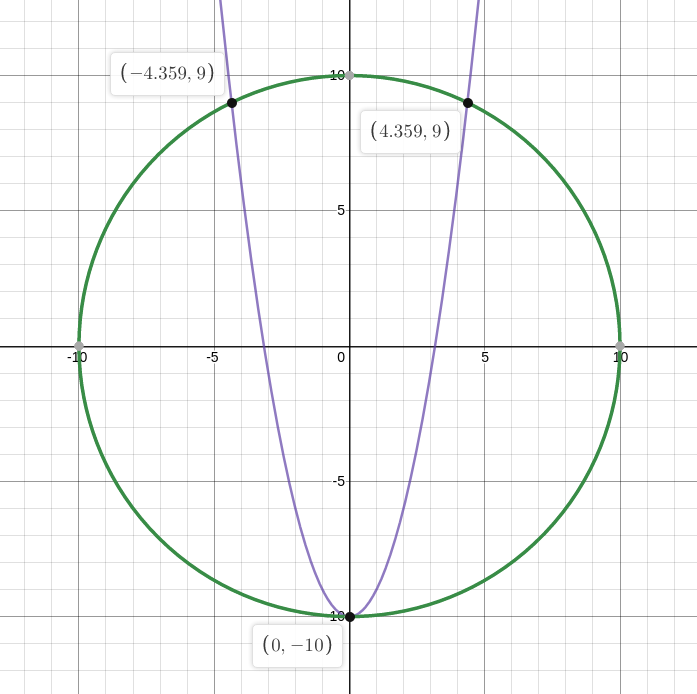

In [ ]:
#função da parabola
def f(x):
    return 2*x**2 -19*x + 24

#derivada
def f_(x):
    return 4*x - 19

#para n iterações
iter = 10

#chute inicial
x = -5

for i in range(iter):
    print(np.round(x,decimals = 2),end=' ')
    x = x - f(x)/f_(x)
    
print(np.round(x,decimals = 2),end=' ')
print()
#chute inicial
x = 5

for i in range(iter):
    print(np.round(x,decimals = 2),end=' ')
    x = x - f(x)/f_(x)
    
print(np.round(x,decimals = 2),end=' ')

-5 -0.67 1.07 1.47 1.5 1.5 1.5 1.5 1.5 1.5 1.5 
5 26.0 15.62 10.67 8.6 8.05 8.0 8.0 8.0 8.0 8.0 

Podemos ver claramente que o método convergiu para as raízes brevemente. Também é perceptível que a raiz para qual o método converge depende do chute inicial.

Agora, para um sistema de equações não-lineares:

A evolução do sistema ocorre da mesma forma, só que a função $F(X)$ é um vetor, e portanto, sua derivada é um Jacobiano.

$${\displaystyle x_{n+1}=x_{n}-J_{F}(x_{n})^{-1}F(x_{n})}$$

No entanto, como é muito trabalhoso calcular a matriz inversa do Jacobiano a cada iteração, podemos reescrever a equação como:

$${\displaystyle J_{F}(x_{n})(x_{n+1}-x_{n})=-F(x_{n})}$$

Assim, resolvemos esse sistema de equações para cada iteração

Vamos calcular a intersecção de uma parábola e um círculo:


$$x^{2}+y^{2}-100=0$$

$$x^{2} - y -10= 0$$

In [ ]:
import numpy as np

#funções:
def Funcao(v):
    x, y = v
    retorno = np.array([x**2 + y**2 - 100, x**2 - y - 10],dtype='float')
    return retorno

#jacobiano das funções
def Jacobiano(v):
    x, y = v
    retorno = np.array([[2*x,2*y],[2*x,-1]],dtype='float')
    return retorno

x = np.array([-1,-1])

for i in range(1000):
    delta = np.linalg.solve(Jacobiano(x),Funcao(x))
    x = x - delta

print(np.round(x,decimals=3))

x = np.array([-10,10])

for i in range(1000):
    delta = np.linalg.solve(Jacobiano(x),Funcao(x))
    x = x - delta

print(np.round(x,decimals=3))

x = np.array([10,10])

for i in range(1000):
    delta = np.linalg.solve(Jacobiano(x),Funcao(x))
    x = x - delta

print(np.round(x,decimals=3))


[  0. -10.]
[-4.359  9.   ]
[4.359 9.   ]


Assim, podemos ver novamente que o sistema converge para o ponto mais próximo do ponto inicial.

# 4 - Método dos Mínimos Quadrados 

  O método dos mínimos quadrados é uma forma de obtenção de funções a partir da minimização do erro de aproximações. Sua maior vantagem é que, pela sua definição, seu resultado será o menos incorreto possível como discutiremos adiante. A aplicação depende de medidas obtidas experimentalmente para fenômenos de forma a gerar alguma expectativa interessante para a lei por trás dos dados, e escolhemos funções que suspeitamos ser pertinentes para calibrar seus coeficientes e representar a lei. Isso não necessariamente implica que a equação obtida pelo método descreve perfeitamente o problema, mas sim possibilita a elaboração de equações a partir de funções familiares que se comportam de forma muito similar à lei estudada no intervalo dado.

  Exploraremos o método dos mínimos quadrados em dois casos: contínuo e discreto. No caso contínuo, trabalhamos com aproximação através de funções contínuas e no discreto a partir de pontos parametrizados no gráfico da função a ser estudada.

**Caso contínuo**

Visto que desejamos uma função que se aproxime o máximo possível da função a ser descoberta, trabalharemos com distâncias entre duas funções. Vamos nos basear, assim, no conceito de norma entre duas funções. Em particular, vamos utilizar a norma euclidiana:

$ \lvert\lvert x \rvert\rvert = \sqrt{(\sum_{i = 1}^{n} \lvert x_i \rvert²)}$

Como estamos trabalhando num espaço vetorial euclidiano, essa norma pode ser compreendida como o produto interno:

$\langle\ x,y\rangle = {\sum_{i = 1}^{n} x_iy_i}$

Se queremos identificar o vetor que mostra a menor distância possível entre um ponto e um vetor, buscamos a **projeção ortogonal** do ponto neste vetor. Considerando um vetor diretor V, assim, queremos um vetor LD a ele $v^*$ que, através de multiplicação por uma constante $\alpha$ , se torne ortogonal ao ponto u cuja distância queremos minimizar. Visto que serão ortogonais, seu produto interno (no caso o produto escalar) deverá igualar 0 e assim podemos calcular a constante $\alpha$ com a expressão:

$\alpha = \frac {\langle\ u,v\rangle} {\langle\ v,v\rangle}$

Generalizando para outros espaços vetoriais, temos o teorema de projeção de sub-espaço da álgebra linear que fundamenta o método dos mínimos quadrados:

Seja $V$ um espaço de dimensão finita de um espaço vetorial $E$. Se $u$ $\in$ $E$, então $v^*$ $\in$ $V$ e a projeção ortogonal de $u$ em $V$ é a melhor aproximação de $u$ em $V$, chamada $v^*$:

$ v^* = \alpha^*_0\phi_0 + ... + \alpha^*_n\phi_n  $

Sendo o vetor $\alpha^*$ a solução do sistema:

$$ \left[ \begin{matrix} \langle\ \phi_0,\phi_0\rangle & ... & \langle\ \phi_0,\phi_n\rangle \\ \vdots & \ddots & \vdots \\ \langle\ \phi_n,\phi_0\rangle & ... & \langle\ \phi_n,\phi_n\rangle \end{matrix} \right] \left[ \begin{matrix} \alpha^*_0\\ \vdots \\   \alpha^*_n \end{matrix} \right] = \left[ \begin{matrix} \langle\ u,\phi_0\rangle\\ \vdots \\  \langle\ u,\phi_n\rangle \end{matrix} \right]
$$

Este é um sistema linear normal e assim existe uma única solução. A aplicação desse teorema para montar o sistema, após discutirmos os objetivos do método, satisfaz o método dos mínimos quadrados.

Para o caso contínuo, utilizando um intervalo fechado $[a, b]$, uma função desconhecida $f(x)$ que queremos aproximar, o polinômio $P_m$ resultado de nossa aproximação e a definição da minimização da distância através do produto interno como minimizar a expressão:

$\int_{a}^{b} ( f(x) - P_m(x))² dx$

(visto que a integral acima representa a distância entre $f$ e $P_m$, através da diferença das áreas das funções),

montamos a partir da base $B = {1, x, x^2, ... , x^n}$ o seguinte sistema linear:

$$ \left[ \begin{matrix} \langle\ 1, 1\rangle & ... & \langle\ 1, x_n\rangle \\ \vdots & \ddots & \vdots \\ \langle\ x_n, 1\rangle & ... & \langle\ x_n, x_n\rangle \end{matrix} \right] \left[ \begin{matrix} \alpha^*_0\\ \vdots \\   \alpha^*_n \end{matrix} \right] = \left[ \begin{matrix} \langle\ 1,f\rangle\\ \vdots \\  \langle\ x_n,f\rangle \end{matrix} \right]
$$

Minimizar esse valor implica em minimizar o quadrado da área entre a função estudada e a função de aproximação.

Do ponto de vista do cálculo, podemos também chegar na mesma conclusão analisando o sistema como resultado da busca pelo mínimo da função quadrática que expressa a diferença entre as áreas das funções, expressa na integral acima. Faremos considerações mais diretas acerca do método nos comentários da implementação.




**Caso discreto**

No caso contínuo, trabalhamos no espaço das funções. Agora usaremos o espaço euclidiano, utilizando pares de coordenadas no $R^2$ para identificar a função de aproximação. Devemos nos atentar para a escolha do polinômio de aproximação: seu grau deve ser **menor** que a quantidade de pontos amostrados da função. Isso impede que montemos um sistema com soluções inúteis para nosso objetivo.

Diferentemente do espaço de funções, nosso produto interno que expressa a norma em um espaço euclidiano será dado pelo produto escalar:

$\langle\ f, g\rangle = {\sum_{k = 0}^{n} f(x_k)g(x_k)}$

Nosso objetivo permanece o mesmo: minimizar a distância entre os pontos dados e a função de aproximação, porém buscaremos essa minimização através do quadrado dessa expressão para podermos utilizar os conceitos de cálculo que apontamos no fim da exposição do caso contínuo. Assim, tendo Q como a função de distância (desvio) que queremos minimizar, transformamos a norma ao quadrado em produto interno entre 2 pares iguais e então no seu produto escalar correspondente:

$ Q = \lvert\lvert f - P_m \rvert\rvert² = \langle\ f - P_m, f - P_m\rangle  = {\sum_{i = 1}^{n} (y_i - P_m(x_k))²} $

Nosso objetivo é assim resolver o seguinte sistema e determinar a melhor solução para as constantes $\alpha_n$ que minimizem o desvio da aproximação:

$P_m(x_0) = \alpha_0^* + \alpha_1^*x_0 + ... + \alpha_n*x_0^m\\
...\\
P_m(x_n) = \alpha_0^* + \alpha_1^*x_0 + ... + \alpha_n*x_0^m
$

Utilizamos $m$ como grau do polinômio para ressaltar que a quantidade $n$ de pontos é distinta da quantidade $m$ de potências de $x$. Como discutimos anteriormente, $m < n$.

Rearticulando esse sistema, representaremos o vetor resultante de todos os $P_m(x_n)$ por $p$ e colocaremos em evidência as potências de $x$ que são multiplicadas pelas constantes $\alpha$, que formam a base do espaço do polinômio. Para cada grau $m$ de um eixo da base, representaremos seu vetor como $u_m$ (por exemplo, no eixo $x^2$ usaremos o vetor $u_2$). Temos, assim:

$p = \alpha_0^*u_0 + \alpha_1^*u_1 + ... + \alpha_m^*u_m$

Continuamos buscando como menor distância as projeções ortogonais de $y$ no subespaço $\mathcal{U} = {u_1, u_2, ... , u_n}$ através das soluções para $\alpha$ geradas pela equação matricial:

$$ \left[ \begin{matrix} \langle\ u_0, u_0\rangle & ... & \langle\ u_0, u_m\rangle \\ \vdots & \ddots & \vdots \\ \langle\ u_m, u_0\rangle & ... & \langle\ u_m, u_m\rangle \end{matrix} \right] \left[ \begin{matrix} \alpha^*_0\\ ...\\   \alpha^*_n \end{matrix} \right] = \left[ \begin{matrix} \langle\ u_0,y\rangle\\ ...\\  \langle\ u_m,y\rangle \end{matrix} \right]
$$


**Considerações sobre os métodos**

Vimos, assim, duas maneiras de compreender um problema para aplicação do $MMQ$. O objetivo e método de obtenção da função de aproximação são essencialmente os mesmos, mas temos uma diferença importante no $espaço$ onde estamos trabalhando: em caso contínuo, no espaço das funções e no caso discreto no espaço euclidiano. Cada espaço terá seu próprio produto interno definido.





**Implementação e aplicação do caso contínuo**

A primeira implementação/aplicação será no caso contínuo. Usaremos este caso para mostrar uma implementação mais simples que a do caso discreto utilizando alguns fundamentos teóricos para facilitar a aplicação específica proposta.

Faremos nossa implementação pautada numa aplicação clássica: a aproximação da função exponencial a partir de uma função polinomial. Este problema em sua forma generalizada é tratado através da série de Taylor e resulta em uma somatória infinita de polinômios com grau crescente, de forma que quanto mais parcelas incluímos na aproximação mais próxima da função exponencial ela se torna. Como alternativa, faremos, para exemplificar o $MMQ$ no caso contínuo, uma versão da aproximação através de uma função polinomial de grau 2 no intervalo $[-1, 1]$.

A escolha dessa aproximação nos permitirá utilizar 3 dos polinômios de Legendre, uma base de polinômios interessante para o caso contínuo. Os polinômios de Legendre são soluções polinomiais da equação diferencial de Legendre e tem como propriedade serem ortogonais no intervalo $[-1, 1]$. Assim, montaremos nosso polinômio de aproximação tendo como base os 3 primeiros polinômios de Legendre:

$
 \phi_1(x) = 1\\
 \phi_2(x) = x\\
 \phi_3(x) = \frac {1} {2} (3x^2 - 1)
$

Relembrando, a matriz que montamos na exposição do caso contínuo para encontrar os coeficientes $\alpha$ utilizava em elementos $a_{ij}$ o produto interno entre dois vetores da base:

$$ \left[ \begin{matrix} \langle\ \phi_1(x), \phi_1(x)\rangle & \langle\ \phi_1(x), \phi_2(x)\rangle & \langle\ \phi_1(x), \phi_3(x)\rangle\\ \langle\ \phi_2(x), \phi_1(x)\rangle & \langle\ \phi_2(x), \phi_2(x)\rangle & \langle\ \phi_2(x), \phi_3(x)\rangle \\ \langle\ \phi_3(x), \phi_1(x)\rangle & \langle\ \phi_3(x), \phi_2(x)\rangle & \langle\ \phi_3(x), \phi_3(x)\rangle \end{matrix} \right]
$$

Entretanto, com nossa escolha de base, nossa matriz ficará bastante simplificada, dado que o produto interno entre vetores ortogonais resulta em 0. Apenas a diagonal principal da primeira matriz possuirá produto interno diferente de 0, assim.

Consideraremos como produto interno o produto escalar:

$\langle f, g \rangle$ = $\int_{-1}^{1} f(x)g(x) dx$

Teremos assim a seguinte matriz:

$$ \left[ \begin{matrix} \langle\ \phi_1(x), \phi_1(x)\rangle & 0 & 0\\ 0 & \langle\ \phi_2(x), \phi_2(x)\rangle & 0 \\ 0 & 0 & \langle\ \phi_3(x), \phi_3(x)\rangle \end{matrix} \right]
$$

As contas para elementos da diagonal principal são integrais relativamente simples e portanto faremos suas operações fora do python para não precisar incluir a biblioteca scipy:

$$
a_{11} = \int_{-1}^{1} 1dx = 2 \\
a_{22} = \int_{-1}^{1} x^2dx = \frac {2} {3} \\
a_{33} = \int_{-1}^{1} (\frac {1} {2} (3x^2 - 1))² = \frac {2} {5}
$$

Para a matriz coluna resultado, precisamos aplicar o produto interno considerando a base com os polinômios de Legendre. Para isso, basta multiplicar a função original $e^x$ por cada vetor da base:

$$
b_{11} = \int_{-1}^{1} 1 * e^x dx = e - \frac {1} {e} \\
b_{22} = \int_{-1}^{1} x * e^x dx = \frac {2} {e} \\
b_{33} = \int_{-1}^{1} e^x \frac {1} {2} (3x^2 - 1) = \frac {e^2 - 7} {e}
$$



Enfim, temos nossa equação matricial montada:

$$ \left[ \begin{matrix} 2 & 0 & 0\\ 0 & \frac {2} {3} & 0 \\ 0 & 0 & \frac {2} {5} \end{matrix} \right] \cdot \left[ \begin{matrix} \alpha_0\\ \alpha_2\\   \alpha_3 \end{matrix} \right] = \left[ \begin{matrix} e - \frac {1} {e}\\ \frac {2} {e}\\  \frac {e^2 - 7} {e}\end{matrix} \right]
$$

Fica evidente agora a maior vantagem de utilizar a base com polinômios de Legendre: restando apenas a diagonal principal, podemos transcrever para o código a solução da equação como uma divisão entre elementos de 2 vetores, $a$ e $b$, sendo o vetor $a$ composto pelos elementos da diagonal principal da matriz A original, de forma que $\alpha_n = \frac {b_n} {a_n}$. Utilizaremos python agora para resolver o sistema, gerar o polinômio e criar o gráfico.


In [ ]:
#MMQ - Implementação do caso contínuo para aplicação de aproximação da função exponencial por função polinomial de grau 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,10)
e = np.e #definimos a constante e para inteligibilidade de código

a = np.array([2, (2/3), (2/5)]) #vetor correspondente aos elementos da diagonal principal de A
b = np.array([(e - (1/e)), (2/e), (((e)**2 - 7)/(e))])

alfa = b/a #divisão dos elementos de b por a, casa a casa

print("Elementos da diagonal principal de A em vetor:")
print(a)
print("Elementos do vetor B:")
print(b)

for i,a in enumerate(alfa):
  print("alfa [" + str(i) + "] = " + str(a))

print(str(alfa[0]) + " + " + str(alfa[1]) + "*x + " + str(alfa[2]) + "*(1/2) * (3x^2 - 1)")
  

Elementos da diagonal principal de A em vetor:
[2.         0.66666667 0.4       ]
Elementos do vetor B:
[2.35040239 0.73575888 0.14312574]
alfa [0] = 1.1752011936438014
alfa [1] = 1.103638323514327
alfa [2] = 0.35781435064737177
1.1752011936438014 + 1.103638323514327*x + 0.35781435064737177*(1/2) * (3x^2 - 1)


Concluímos a exposição do caso contínuo com o gráfico comparando $MMQ$, a função exponencial e o resultado da aproximação por série de Taylor até o grau 2 no intervalo -1 a 1:

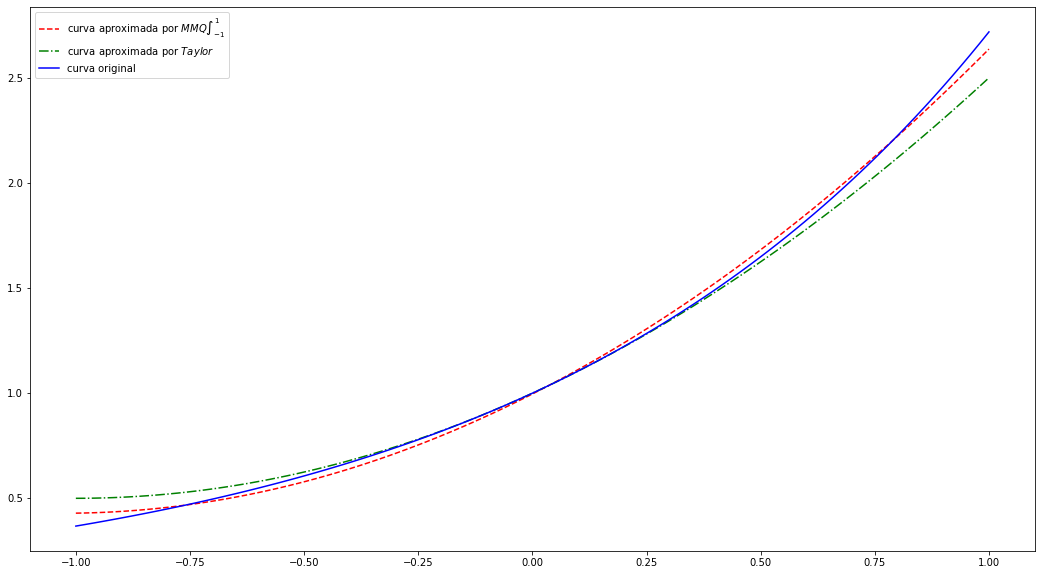

In [ ]:
x = np.linspace(-1,1,100)
y = 1.1752011936438014 + 1.103638323514327*x + 0.35781435064737177 * ((1/2) * ((3*x**2) - 1))

x2 = np.linspace(-1,1,100)
y2 = np.exp(x2)

x3 = np.linspace(-1,1,100)
y3 = 1 + x + x**2/2

plt.plot(x,y,color='red',linestyle='--',label='curva aproximada por $MMQ\int_{-1}^{1}$')
plt.plot(x3,y3,color='green', linestyle = '-.', label='curva aproximada por $Taylor$')
plt.plot(x2,y2,color='blue',label='curva original')

plt.legend()
plt.show()



**Implementação e aplicação do caso discreto**

Aplicaremos o caso discreto no .txt que mostra casos de COVID de 16 de Abril até 31 de Julho de 2020, gerado com dados da World Health Organization. Utilizaremos, primeiro, um breve trecho do código disponibilizado pela monitora Camila Lages para visualizar os dados, com algumas alterações para comparar o comportamento dos dados com uma função cúbica.

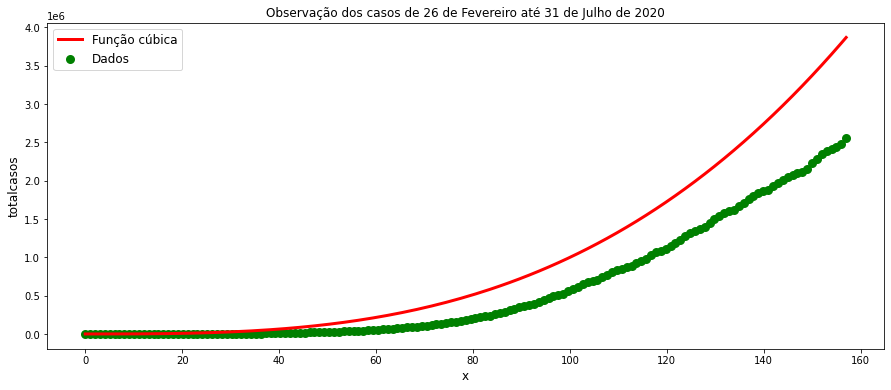

In [ ]:
#Geração de pontos a partir do .txt disponibilizado
totalcasos = np.genfromtxt(fname='dados_covid_atualizados.txt') # y
dias = np.linspace(0, 157, num=157, endpoint=True) # x

yy = np.power(dias, 3) # Adicionamos a função cúbica no gráfico para comparação

# Plotagem dos dados
plt.figure(figsize=(15,6),facecolor='white')

plt.scatter(dias,totalcasos,label = 'Dados',linewidth = 3,color='green')
plt.plot(dias,yy,label = 'Função cúbica',linewidth = 3,color='red')

plt.xlabel('x',fontsize='large')

plt.ylabel('yy',fontsize='large') 
plt.ylabel('totalcasos',fontsize='large') 

plt.title('Observação dos casos de 26 de Fevereiro até 31 de Julho de 2020') 
plt.legend(fontsize='large') 
plt.show()



A função cúbica serve bem para nosso exemplo por conter um número muito menor de termos que pontos que temos para fazer nossa aproximação. Como discutimos na exposição teórica, estamos no espaço euclidiano agora e portanto nosso produto escalar será dado por:

$\langle\ f,g\rangle = {\sum_{k = 0}^{n} f(x_k)g(x_k)}$

Usaremos para este cálculo o produto escalar já implementado no numpy, que se comporta exatamente da mesma maneira.

Queremos que nosso resultado seja do tipo:

$f(x) = \alpha_0 + \alpha_1x + \alpha_2x^2 + \alpha_3x^3$

Precisaremos assim de 4 vetores no sub-espaço $ \mathcal{U}$. Ao invés de calcular manualmente os vetores, utilizaremos o método implementado do numpy para obtenção de matrizes de Vandermonde. A matriz de Vandermonde implementada no numpy, entretanto, nos retornará os vetores $u_n$ em linhas, mas precisaremos deles em colunas para nossa equação matricial. Assim, precisaremos aplicar a transposição para gerar uma matriz $A$ adequada para a equação.

Em seguida, precisaremos calcular propriamante os valores em $A$ através do produto escalar que definimos na exposição teórica do caso discreto de $MMQ$, e da mesma forma aplicar o escalar entre os pontos de y e os $u_n$. Montadas nossa matriz e vetores, usamoms o linalg.solve do numpy para obter as constantes e aplicamos em um polinômio.

In [ ]:
    #Implementação do MMQ discreto    
    preA = np.vander(dias,4) # geramos a matriz de Vandermonde 4x4 (para polinômio grau 3) a partir do número de dias no eixo x
    
    A = np.transpose(preA).dot(preA) #precisamos transpor a matriz antes de aplicar o produto escalar, visto que a 
    #implementação do numpy retorna a matriz com os vetores u_n em linhas e precisamos deles em colunas para
    #nossa equação matricial. Em seguida, já aplicamos o produto escalar entre os vetores da matriz.

    b = np.transpose(preA).dot(totalcasos) #preparação do vetor b através do escalar entre u_n e pontos y

    x = np.linalg.solve(A,b) #solução da equação matricial
    
    x_decimals = np.round(x, 3) #arredondamos a quantidade de casas decimais para melhor visualização
    
    #print do polinômio aproximado:
    print(str(x_decimals[3]) + " + " + str(x_decimals[2]) + "*x + " + str(x_decimals[1]) + "*x^2 + " + str(x_decimals[0]) + "*x^3")


49173.092 + -4058.289*x + 30.735*x^2 + 0.635*x^3


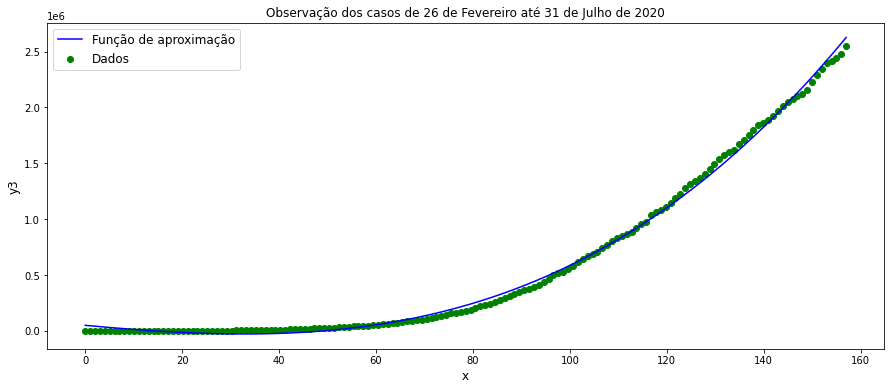

In [ ]:
#função obtida pelo MMQ discreto
y3 = 49173.092 -4058.289*dias + 30.735*(dias**2) + 0.635*(dias**3)

# Plotagem dos dados originais comparados à função aproximada
plt.figure(figsize=(15,6),facecolor='white')

plt.scatter(dias,totalcasos,label = 'Dados', color='green')
plt.plot(dias,y3,label = 'Função de aproximação', color='blue')

plt.xlabel('x',fontsize='large')
plt.ylabel('yy',fontsize='large') 
plt.ylabel('totalcasos',fontsize='large')
plt.ylabel('y3',fontsize='large')

plt.title('Observação dos casos de 26 de Fevereiro até 31 de Julho de 2020') 
plt.legend(fontsize='large') 
plt.show()



# 5 - Interpolação Polinomial

**O Problema**

Dados $(n + 1)$ pontos em um plano cartesiano (existe a possibilidade de estender as dimensões do problema, o que o torna significativamente mais complexo), queremos encontrar uma função, mais especficamente um polinômio de ordem $n$ denotado por $\mathcal{P}_n(x)$ que passe por todos os pontos dados. Ou seja, queremos que para cada ponto $$p_i = (x_i, y_i) \;, x_i > x_{i-1}$$ $$ \mathcal{P}_n(x_i) = y_i$$

Intuitivamente pode-se notar que se o polinômio desejado tiver liberdade de grau qualquer podem existir inúmeras soluções, basta imaginar as várias formas que se pode traçar uma linha suave interligando todos os $(n + 1)$ pontos. Entretanto, quando restringimos para o grau $n$ é um resultado que apenas existe uma possibilidade de solução. 

**Prova de Unicidade**:

Suponha que existam dois polinômios que satisfaçam as condições do problema $$\mathcal{P}_1(x_i) = \mathcal{P}_2(x_i) = y_i$$ tal que $deg(\mathcal{P}(x)) \leq n$, então a diferença desses dois polinômios $\mathcal{D} = \mathcal{P}_1 - \mathcal{P}_2$ também teria grau menor ou igual a $n$ e satisfaria $\mathcal{D}(x_i) = 0$ para todo $y_i$. Como o número de raízes de todo polinômio não-nulo é igual ao seu grau e já encontramos $(n + 1)$ raízes para $\mathcal{D}$ (uma para cada nóó interpolador), concluimos que $\mathcal{D}$ deve ser o polinômio nulo, e, portanto: $$\mathcal{D} = \mathcal{P}_1 - \mathcal{P}_2 = 0 \implies \mathcal{P}_1 = \mathcal{P}_2$$.

Como a construção é geral, concluímos que o polinômio solução é único.

**Sistemas Lineares**

Sabemos que encontrar o polinômio $\mathcal{P}_n(x)$ é o mesmo que encontrar todos os coeficientes $a_i$ deste, sendo $i = 0, ..., n$

Para isso expressamos o que precisamos na forma matricial, o que é uma ideia temática: $X = 
\begin{pmatrix}
1 & x_0 & x_0² & \cdots & x_0^n \\
1 & x_1 & x_1² & \cdots & x_1^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n² & \cdots & x_n^n \\ 
\end{pmatrix}$$A = 
\begin{pmatrix}
a_0 \\
a_1 \\
\vdots\\
a_n \\
\end{pmatrix}$$ Y = \begin{pmatrix}
y_0 \\
y_1 \\
\vdots\\
y_n \\
\end{pmatrix}$

Então temos um sistema linear com n equações e n variáveis desconhecidas a descobrir (todos os $a_i$): $$XA = Y$$

A matrix $X$ é conhecida como Matriz de Vandermont, e possui um cálculo simples de determinante que nos possibilita rapidamente demonstrar a existência da solução:
  $$ det(X) = \displaystyle\prod_{i<k} x_k - x_i $$
  Como $x_i$ e $x_k$ nunca são os mesmos nessa matriz, temos que nenhum termo do produtório se anulará, e portanto o determinante da matriz não é nulo.

Para de fato encontrar a solução para esse sistema, entretanto, precisamos efetuar operações de inversão na matriz $X$ para alcançar $A = YX^{-1}$ . Sabemos que isto é custoso computacionalmente e apresenta grandes problemas de escalabilidade, conforme $n$ cresce. É por isso que buscamos outras alternativas para encontrar o polinômio.

**Interpolação de Lagrange**

Uma forma desenvolvida encontrar todos os $a_i$ sem o custo mencionado anteriormente é fazendo uso de uma construção ligeiramente mais complexa, com uma base vetorial diferente, proporcionando ao final uma matriz identidade, o que descarta o custo de inversão da mesma, já que $I = I^{-1}$

Para isso, construímos o polinômio de interpolação $$\mathcal{L}_n(x_i) = y_0 \ell_0(x_i) + y_1 \ell_1(x_i) + \cdots + y_0 \ell_n(x_n) = y_i$$

Onde $\ell_i$ são os polinômios de Lagrange, que respeitam a seguinte relação:
  $$\ell_k(x_i) = \delta_{ij} =
    \begin{cases}
            1, &         \text{if } i=j,\\
            0, &         \text{if } i\neq j.
    \end{cases}$$

Isso porque queremos que nos pontos $x_i$ o valor de $\ell_k(x_i)$ preserve o valor de $y_i$, multiplicando-o por 1, enquanto anula-se os outros termos multiplicando-os por zero. Assim garantimos que todos os pontos coincidem com a curva polinomial, enquanto simplificamos a matriz $L$ para uma matriz identidade se representarmos a equação na forma matricial.

A forma que se constrói para obter esse comportamento desejado é a seguinte:
$$\ell_k(x) = \prod_{i = 0\\i \neq k}\dfrac{x - x_i}{x_k - x_i}, ~ k = 0, \cdots, n$$

E isso certifica que para $\ell_k(x_i) = 0$, se $i \neq k$ pois o numerador de um termo do produtório é $0$, enquanto $\ell_i(x_i) = 1$.

Portanto, basta resolver os cálculos para determinar cada $\ell_k$ e em seguida efetuar $$\sum_{k=0}\ell_ky_k = \mathcal{L}(x).$$




**Implementação da Interpolação de Lagrange**

Compararemos esta com a implementação da biblioteca scipy, acessível por scipy.interpolate.lagrange(x, w), que toma como parâmetros um array de pontos x e outro de pontos w, representando assim os conjuntos $x_i$ e $y_i$, e retorna um objeto do tipo numpy.poly1d representando o polinômio resultante.

Com o intuito de gerar uma alternativa à essa função, a implementação aqui apresentada recebe por parâmetro uma lista de tuplas (no caso os pares de pontos x,y) e, além disso, um valor x. De forma que o uso dessa função não é retornar em si o polinômio como na da biblioteca, mas o valor y do polinômio no ponto x passado por parâmetro, de forma que dependendo da estruturação do programa que a usa, esta pode se tornar uma opção mais agradável.

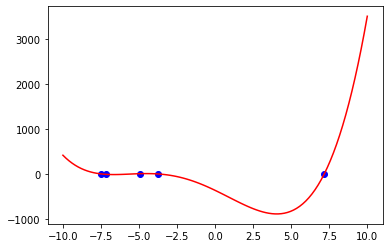

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as random

def lagrange_interpolation(pts, x):
	n = len(pts)
  # l é um array onde cada posição k representa um lk(x)
	l = np.zeros((n))
  # res é o valor final da função no ponto dado, calculado com o somatório do produto de cada posição de l com o valor dos valored de y correspondentes
	res = 0
  # iteramos sobre os pontos uma vez, incrementando k
	for k, (xk, yk) in enumerate(pts):
		l[k] = 1
    # iteramos sobre os pontos novamente, incrementando i
		for i, (xi, yi) in enumerate(pts):
      # dada a restrição do delta de kronecker, devemos pular a iteração caso i == k, para que l[k] quando x = xk seja 1, e não 0
			if (i == k):
				continue
			l[k] *= (x - xi)/(xk - xi)
		res += l[k] * yk
	return res

# como teste: 
# geramos um conjunto de pontos aleatórios e plotamos
pts = np.array([[random.uniform(-10, 10), random.uniform(-10, 10)] for i in range(5)])
plt.scatter(pts[:,0], pts[:,1], color="blue")

# geramos um gráfico para o polinômio gerado pelo método acima
x = np.linspace(-10, 10, 100)
y = np.zeros((100))
for i in range(100):
	y[i] = lagrange_interpolation(pts, x[i])
plt.plot(x, y, color="red")
plt.show()

**Interpolação de Newton**

Um dos detalhes do método de Lagrange é que com ele não são suportadas adições de nós de interpolação sem a necessidade de se recalcular tudo o que foi anteriormente calculado. Nesse ponto, o método usando Polinômios de Newton mostra-se um avanço.

Este se trata de um modo incremental de se encontrar um polinômio interpolador, no sentido de que, ponto a ponto, vai-se atualizando o polinômio gerado para tornar-se mais preciso, e é por isso que sempre pode-se adicionar um ponto a mais aproveitando o trabalho anterior.

A construção se dá da seguinte forma:

Partimos de um polinômio $\mathcal{P}_0(x)$ em que a única restrição que se impõe é que em $x_0$ ele retorne $y_0$. Satisfaremos isso da forma mais simples, declaramos que $\mathcal{P}_0(x) = y_0$. Ou seja, tomamos uma função constante que para todo valor de x satisfaz $y_0$. Agora incrementamos o polinômio com o próximo nó interpolador adicionando um termo $\alpha_0$ da seguinte forma: $$\mathcal{P}_1(x) = \mathcal{P}_0(x) + \alpha_0(x - x_0)$$

Assim garantimos que a restrição anterior de passar pelo ponto $(x_0, y_0)$ se cumpra, pois ao avaliarmos em $x_0$ o termo adicional é anulado: $$\mathcal{P}_1(x_0) = y_0 + \alpha_0(x_0 - x_0)$$
$$\mathcal{P}_1(x_0) = y_0$$

Podemos então encontrar o termo $\alpha_0$ ao avaliarmos $\mathcal{P}_1$ em $x_1$, impondo novamente a condição de que o valor resultante deve ser $y_0$, e em seguida manipulando a equação da direita, já que todos os termos exceto $\alpha$ são conhecidos: $$\mathcal{P}_1(x_1) = \mathcal{P}_0(x_1) + \alpha_0(x_1 - x_0) = y_1$$
$$y_0 + \alpha_0(x_1 - x_0) = y_1$$
$$\alpha_0 = \dfrac{y_1 - y_0}{x_1 - x_0}$$

E essa mesma construção pode ser feita para cada novo ponto, seguindo a forma recursiva geral: $$\mathcal{P}_n(x) = \mathcal{P}_{n-1}(x) + \alpha_{n-1}(x - x_0)(x - x_1) \cdots (x - x_{n-1})$$

Perceba que o termo $\alpha_i$ sempre é acompanhado de mais termos multiplicando-o, conforme $i$ cresce, e podemos descrever esse processo mais rigorosamente com **diferenças divididas**, que por sua vez são definidas recursivamente:

$$f[xi]:=f(xi) \;\; i=0, . . . ,n$$ $$f[xi,xi+1, . . . ,xi+k]:=f[xi+1,xi+2, . . . ,xi+k]−f[xi,xi+1, . . . ,xi+k−1]xi+k−xi$$ com $k=1, . . . ,n$ e $i=0, . . . ,n−k.$

** bold textImplementação do Método de Interpolação de Newton**

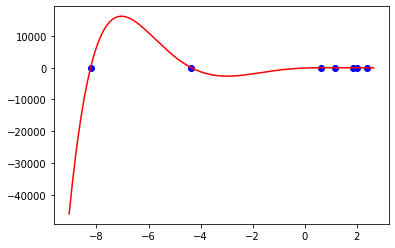

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as random

# aqui geramos a tabela de diferenças divididas, partindo de
# a[0] = y[0] e construindo os alphas
def div_dif(pts, n):
	x = np.copy(pts[:,0])
	a = np.copy(pts[:,1])
	for i in range(1, n):
		 a[i:n] = (a[i:n] - a[i-1]) / (x[i:n] - x[i-1])
	return a

# Primeiramente chamamos a função que constrói os alfas e em seguida
# iteramos sobre os graus do polinômio, do mais alto para o mais baixo, completando
# o processo recursivo quando alcançamos enfim p = a[0], e retornamos o polinomio
def newton_interpolation(pts, x):
	n = len(pts)
	a = div_dif(pts, n)
	n = n - 1
	p = a[n]
	for i in range(1, n+1):
		p = a[n-i] + p * (x - pts[:,0][n-i])
	return p

pts = np.array([[random.uniform(-10, 10), random.uniform(-10, 10)] for i in range(7)])
pts[:,0] = np.sort(pts[:,0])
plt.scatter(pts[:,0], pts[:,1], color="blue")

x = np.linspace(pts[0,0]*1.1, pts[len(pts)-1,0]*1.1, 200)
y = np.zeros((200))

for i in range(200):
	y[i] = newton_interpolation(pts, x[i])
plt.plot(x, y, color="red")
plt.show()


**Interpolação de Hermite**

Se quisermos uma opção que permite que possamos obter um polinômio cujas derivadas até ordem $m$ se igualem às derivadas da função original a ser interpolada, podemos usar este método.

Para satisfazer essa condição das derivadas, entretanto, devemos permitir que o polinômio interpolador tenha grau até $n(m + 1) - 1$, em contraponto ao grau $n-1$ no método anterior (considerando $n$ nós). Assim, obteremos um polinômio de grau $g$, $ n - 1 \leq g \leq n(m + 1) - 1$.

Sua construção é muito similar à da forma de Newton, fazendo uso de diferenças divididas também, mas com uma forma que descreve as derivadas com limites:

$$j = 2, 3 . . . , m$$

$$f[xi, . . . ,xi] = \frac{f^{(j)} x_i}{j!}$$

A forma como incluimos as diferenças divididas no polinômio é muito similar à de Newton:

$$ H_{2n+1}^{(j)}(x_i) = c_{ij}$$

Onde $c_{ij}$ se relaciona da seguinte forma com as diferenças divididas, lembrando que $j$ é a ordem da derivada, e também a quantidade de termos $x_i$ dentro de $f$:

$$f[x_i, ... , x_i] = c_{ij} = \alpha_j$$

Sendo todos os $x_i$ idênticos para cada ponto, e a contagem total deles é $j$ para cada cálculo, pois consideramos $j$ derivadas.

Se tomarmos a forma explícita usando $H_3(x)$ como exemplo, vemos a semelhança com o método de Newton, especialmente pois tomamos a decisão de usar letra $\alpha$:

$$H_3(x) = \alpha_0 + \alpha_1(x - x_0) + \alpha_2(x - x_0)^2 + \alpha_3(x - x_0)^2(x - x_1)$$

Note que o número de nós que usamos é menor do que o grau do polinômio resultante, como discutido anteriormente.

**Erro na Interpolação para os Métodos de Interpolação de Lagrange e Newton**

Como em grande parte dos métodos numéricos, dada sua natureza, é interessante discutirmos métricas de erro. Podemos estabeler uma relação simples de diferença entre a função e o polinômio em dado ponto, Dados $f ∈ C^{n+1}([a,b]),$ $a=x_0< x_1<···< x_n = b $

 e sendo $ P_n(x)$ o polinômio de interpolação de uma função $f(x)$: $$E_n(x) =f(x)−P_n(x) =\frac{f(n+1)(ξ)}{(n+1)!}\prod_{i=0}(x−x_i)$$ 

 Onde $ξ = ξ(x)$, estando no intervalo $[-1, 1]$ e existe pra todo ponto $x_0$ de forma a satisfazer a igualdade.

 Podemos então tomar escolhas arbitrárias de tolerância para erro, por exemplo como condição de parada para um ou outro algoritmo numérico.


**Fenômeno de Runge**

Percebe-se que para os métodos apresentados acima, ao aumentarmos a quantidade de nós de interpolação, e em especial se eles estiverem próximos de equidistantes entre si, temos uma oscilação grande da função polinomial, o que tende a aumentar exponencialmente o erro quando comparado com a função original. Tomemos como exemplo a função de Runge definida como $$f(x)={\frac {1}{1+25x^{2}}}$$

Interpolada com diferentes números $N$ de nós interpoladores.  Carl David Tolmé Runge descobriu-a e desde então há um forte argumento para que o aumento da ordem de polinômios e nós de interpolação não represente um sinônimo de melhoria na precisão, ou minimização de erro.

![Função muito oscilante nas extremidades do intervalo dado pelos pontos](https://www.researchgate.net/profile/Denys_Dutykh/publication/304127935/figure/fig2/AS:374892726898689@1466392799841/Interpolation-of-the-Runge-function-f-x_Q320.jpg)

Isso ocorre essencialmente pois, ao aumentarmos o grau do polinômio nos métodos de interpolação, a magnitude a $n$-ésima derivada cresce mais rápido conforme $n$, dentre outros fatores.

Esse é um dos problemas mais discutidos quando se trata de interpolação polinomial, e é um dos motivos por que um dos próximos assuntos, Splines, é relevante para diversas áreas.

**Nós de Chebyshev**

Uma forma de mitigar os efeitos do fenômeno de Runge é fazer uma escolha mais cuidadosa dos nós de interpolação, em especial evitando que eles sejam equidistantes. Para isso podemos usar os nós de Chebyshev, que são as raízes do polinômio de Chebyshev de primeira ordem.

Descrevemo-os:

$$ x_{k}=\cos \left({\frac {2k-1}{2n}}\pi \right),\quad k=1,\ldots ,n.$$

Um exemplo visual:
![Nós mais próximos entre si nas extremidades do intervalo [a,b]](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Chebyshev-nodes-by-projection.svg/1024px-Chebyshev-nodes-by-projection.svg.png)

**Splines**

Aqui começamos uma abordagem distinta das anteriores, e ao invés de encontrarmos um único polinômio $P_n(x)$ que coincida com o conjunto de nós dado, nós encontraremos polinômios de graus menores, ligando apenas dois pontos do conjunto por vez, assim garantindo que minimizamos o fenômeno de Runge, enquanto possibilitamos uma construção por partes da curva final composta pela junção dos $n - 1$ polinômios que interligam os $n$ nós.

Assim, um spline é definido por uma função polinomial $S ∈ C^{n−1}([a,b])$, onde $S(x_i) = y_i$ e $$S = P_{k-1}(x), x_{k-1} \leq x \leq x_{k}$$.

Podemos tomar polinômios $P_k(x)$ de qualquer ordem, e este é um modo de classificar splines.

Com splines lineares, os polinômios são de ordem 1, ou seja, retas, a função $S$ final liga todos os pontos dados por retas, par a par, ligando o primeiro ao segundo, o segundo ao terceiro, e assim por diante.

Com aplicações mais sofisticadas temos Splines Cúbicas, que normalmente parecem suaves ao olho nu, mas evidentemente dependendo da escolha dos nós e sua quantidade.

Para Splines Cúbicas queremos que as condições apresentadas anteriormente sejam cumpridas, e além disso as derivadas até a ordem $2$ devem coincidir com a da função original de interpolação: $$S_{3,i}(x_{i+1}) = S_{3,i+1}(x_{i+1}),$$
$$S_{3,i}'(x_{i+1}) = S_{3,i+1}'(x_{i+1}),$$
$$S_{3,i}''(x_{i+1}) = S_{3,i+1}''(x_{i+1}).$$

Como subclassificações temos Splines Cúbicas Naturais e Fixadas, onde para cada uma temos uma restrição de contorno distinta:

**Natural**: $$S′′_3(x_0) =S′′_3(x_n) =0$$
**Fixada**: $$S′_3(x_0) =f′(x_0), S′_3(x_n) =f′(x_n)$$

Resumidamente na fixada garantimos que no primeiro e último pontos as derivadas de primeira ordem de $S$ e $f$ coincidem, enquanto na natural fazemos o mesmo mas com as derivadas de segunda ordem, e além disso restringimo-as ao valor nulo, o que garante que temos pontos de inflexão, e que fora do intervalo delimitado a função se comporta como uma reta, sem quebra de suavidade.

Tomaremos a forma geral explícita:
$${S}_{j}\left(x\right)=a_{j}+b_{j}\left(x-x_{j}\right)+c_{j}{\left(x-x_{j}\right)}^{2}+d_{j}{\left(x-x_{j}\right)}^{3}$$

Com isso, basta avaliar cada parte dada no valor necessário $x_j$ e aplicar a condição de igualdade para que o valor resultante seja $y_j$. Como sabemos todos os valores dos pontos, essa tarefa torna-se simples e direta.

Interpolação da função de Runge com splines:
![alt text](https://www.google.com/url?sa=i&url=https%3A%2F%2Fhelp.scilab.org%2Fdocs%2F6.0.0%2Fen_US%2Fsplin.html&psig=AOvVaw3QfqoxuqfWrHI-Wn_AldM7&ust=1596333119805000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCJDL_rby-OoCFQAAAAAdAAAAABAJ)

**Aplicação**

Como exemplo simples, podemos imaginar uma situação em que queremos simular um caminho suave que um veículo ou objeto qualquer percorre, dados $n$ lugares em que o veículo deve passar por.

Para simular isso a próxima célula de código gera $n$ pares de valores aleatórios, um $x$ e um $y$ para cada par, e será plotada a trajetória para alcançar cada um deles, então são gerados k novos conjuntos de pares. Como o método é feito por etapas, podemos continuamente realimentar o programa com novos pontos.

1o conjunto de maçãs:


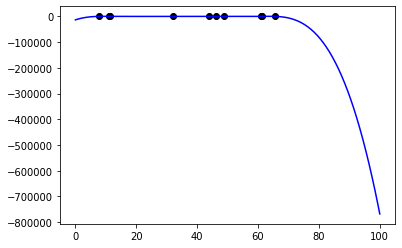

2o conjunto de maçãs:


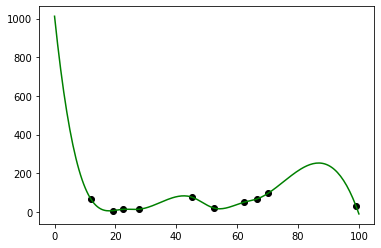

3o conjunto de maçãs:


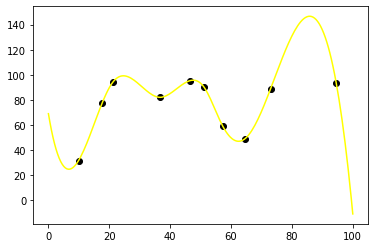

4o conjunto de maçãs:


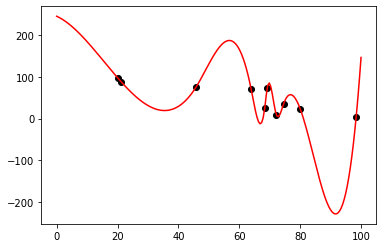

In [ ]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np

n = 10
k = 4
pr = 200
colors = ["blue", "green", "yellow", "red"]

for i in range(k):
	print(str(i + 1) + "o conjunto de maçãs:")
	x = np.random.uniform(low=0, high=100, size=n)
	y = np.random.uniform(low=0, high=100, size=n)
	x = np.sort(x)
	path = CubicSpline(x, y)
	plt.scatter(x, y, color="black")
	x_cont = np.linspace(0, 100, pr)
	plt.plot(x_cont, path(x_cont), color=colors[i])
	plt.show()

# 6 - Integração Numérica (Cálculo de integrais que não possuem solução analítica)

Utilizamos a integração numérica para solucionar integrais definidas com uma abordagem alternativa à antiderivada, quando encontramos funções que possuem antiderivadas demasiado complexas ou mesmo impossíveis de serem resolvidas (isto é, sem solução analítica). 
 
Para demonstrar integração numérica utilizaremos a regra do ponto médio. Baseada no conceito de soma de Riemann, onde particionamos um intervalo cada vez mais vezes em retângulos com área de valor $base * altura$, a regra do ponto médio divide arbitrariamente uma função avaliada no intervalo $[a,b]$ em N sub-intervalos regulares. O comprimento de cada um desses intervalos, por serem regulares, pode ser expresso assim como:

$h = \frac {(b - a)} {N} $

Os valores de $f$ ao longo do intervalo constituem a altura dos retângulos. Aplicaremos $f$ no ponto médio  $\overline{x}$ entre $x_k$ e $x_{k-1}$:

$\int_{x_0}^{x_N} f(x) dx \approx h \sum _{k=1}^{N} f(\overline{x}_k)$

Sendo

$\overline{x}_k = \frac { x_{k-1} + x_k} {2} $

Na nossa implementação, utilizaremos valores arbitrários para $N$, demonstrando o impacto da quantidade de partições no resultado.



Primeiramente vamos demonstrar a técnica de integração numérica com uma função com antiderivada conhecida: $f(x) = x^3$. Sabemos que sua antiderivada é $F(x) = \frac {x^4} {4} + C$ mas não nos preocuparemos com a constante de integração por buscarmos a integral definida. Vamos avaliar essa integral definida no intervalo $[0, 10]$ e comparar sua solução com a soma de Riemann. Sabemos de antemão que, pelo teorema fundamental do cálculo:

$\int_{0}^{10} x^3dx = 2500$



In [ ]:
import numpy as np
#a e b serão os argumentos dos limites de integração, N o número de partições dos intervalos
#e h a altura da função via teorema do ponto médio.
a = 0
b = 10
N = 100 
h = (b-a)/N

soma = 0
for x in np.linspace(a,b,N):
    soma += h*np.power(x,3)
    
print(soma)

2525.252525252525


In [ ]:
#Veja como na segunda versão com 10 vezes mais partições esse valor se aproxima ainda mais do esperado:
a = 0
b = 10
N = 1000 
h = (b-a)/N

soma = 0
for x in np.linspace(a,b,N):
    soma += h*np.power(x,3)
    
print(soma)

2502.502502502504


Agora, aplicaremos a soma de Riemann a uma integral definida cuja antiderivada não somos capazes de calcular, a curva normal $e^{-x^2}$ no intervalo $]-\infty, \infty[$ . Faremos, por motivos práticos, os limites $[a, b]$ iguais a $[-10, 10]$ em nosso código, garantido um intervalo onde os valores de $y$ já decresceram para valores suficientemente pequenos para nossos propósitos

$$\int_{-10}^{10} e^{-x^2} dx = \sum _{i=0}^{N} e^{-(a+hi)²} \cdot $$



In [ ]:
import numpy as np

a = -10
b = 10
N = 1000000
h = (b-a)/N

soma = 0
for x in np.linspace(a,b,N):
    soma += h*np.exp(-np.power(x,2)) #curva normal
    
print(soma)

1.7724520784513451


Sabemos entretanto que a área embaixo da curva normal é dada por $\sqrt\pi$. Assim, calcularemos o erro da aproximação, dado pela diferença entre o valor conhecido e o valor obtido pela soma de Riemann:

In [ ]:
print(np.abs(soma-np.sqrt(np.pi)))

1.7724541707675456e-06


Por fim, faremos um comparativo entre a regra do ponto médio e a regra do trapézio composta. Enquanto a regra do ponto médio utiliza área de retângulo como base para a somatória, utilizamos na regra do trapézio composta partições em formato de trapézio, conectando $f(x_{N-1})$ a $f(x_N)$ com segmentos de reta e utilizando a fórmula da área do trapézio de acordo no algoritmo, $(B + b) * \frac {h} {2}$:

In [ ]:
#implementação por trapézios:
soma = 0
K = int(N/2)
for x in np.linspace(a,b,num=N):
    soma += (h*(np.exp(-np.power(x+h,2))+np.exp(-np.power(x,2))))/2
    
print(soma)

1.7724520784513236


In [ ]:
#Cálculo do erro pela regra dos trapézios:
print(np.abs(soma-np.sqrt(np.pi)))

1.7724541923058723e-06
